In [1]:
# import spark sql
from pyspark.sql import SparkSession

In [2]:
## import spark sql functions
from pyspark.sql.functions import *

In [3]:
# create spark session with 16 threads
spark = SparkSession.builder.master('local[16]').getOrCreate()

22/11/09 12:37:37 WARN Utils: Your hostname, extrieve resolves to a loopback address: 127.0.1.1; using 10.224.151.121 instead (on interface wlo1)
22/11/09 12:37:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/09 12:37:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/09 12:37:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
# Load data frame
df = spark.read.csv('blood.csv', header=True, inferSchema=True)

In [5]:
# print schema
df.printSchema()

root
 |-- Recency (months): double (nullable = true)
 |-- Frequency (times): integer (nullable = true)
 |-- Monetary (c.c. blood): integer (nullable = true)
 |-- Time (months): double (nullable = true)
 |-- whether he/she donated blood in March 2007: integer (nullable = true)



In [6]:
# head
df.show(5)

+----------------+-----------------+---------------------+-------------+------------------------------------------+
|Recency (months)|Frequency (times)|Monetary (c.c. blood)|Time (months)|whether he/she donated blood in March 2007|
+----------------+-----------------+---------------------+-------------+------------------------------------------+
|             2.0|               50|                12500|         98.0|                                         1|
|             0.0|               13|                 3250|         28.0|                                         1|
|             1.0|               16|                 4000|         35.0|                                         1|
|             2.0|               20|                 5000|         45.0|                                         1|
|             1.0|               24|                 6000|         77.0|                                         0|
+----------------+-----------------+---------------------+-------------+

In [7]:
# column names
df.columns

['Recency (months)',
 'Frequency (times)',
 'Monetary (c.c. blood)',
 'Time (months)',
 'whether he/she donated blood in March 2007']

## Making columns lowercase and splitting based on the first space for convenience

In [8]:
# change column names to lower case and split by space, only keep first word
df = df.toDF(*[c.split(' ')[0].lower() for c in df.columns])

df.columns

['recency', 'frequency', 'monetary', 'time', 'whether']

# Answering question 1-6 simple spark.sql queries

In [9]:
# average of the recency column
df.select(avg('recency')).show()

+-----------------+
|     avg(recency)|
+-----------------+
|9.506684491978609|
+-----------------+



In [10]:
# Maximum of the frequency column
df.select(max('frequency')).show()

+--------------+
|max(frequency)|
+--------------+
|            50|
+--------------+



In [12]:
# counts of the frequency column, sorted by frequency
df.groupBy('frequency').count().sort('frequency').show()

+---------+-----+
|frequency|count|
+---------+-----+
|        1|  158|
|        2|  112|
|        3|   87|
|        4|   62|
|        5|   62|
|        6|   52|
|        7|   43|
|        8|   31|
|        9|   24|
|       10|   14|
|       11|   22|
|       12|   14|
|       13|    9|
|       14|   13|
|       15|    6|
|       16|   13|
|       17|    4|
|       18|    1|
|       19|    2|
|       20|    2|
+---------+-----+
only showing top 20 rows



In [14]:
# check the count of 1 in the whether he donated blood in March 2007 column
df.filter(df['whether'] == 1).count()

178

# Performing the multivariate regression analysis

In [15]:
# Lets import the necessary libraries to perform multiple linear regression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

In [16]:
df.columns

['recency', 'frequency', 'monetary', 'time', 'whether']

## Vectorizing the regression inputs

In [17]:
# Lets build a model with whether as the dependent variable and the rest of the columns as the independent variables
# Lets create a vector assembler to combine all the independent variables into a single vector
assembler = VectorAssembler(inputCols=['recency', 'frequency', 'monetary', 'time'], outputCol='features')

In [18]:
# Lets transform the data frame using the vector assembler
output = assembler.transform(df)

# Lets print the first 5 rows of the transformed data frame
output.show(5)

+-------+---------+--------+----+-------+--------------------+
|recency|frequency|monetary|time|whether|            features|
+-------+---------+--------+----+-------+--------------------+
|    2.0|       50|   12500|98.0|      1|[2.0,50.0,12500.0...|
|    0.0|       13|    3250|28.0|      1|[0.0,13.0,3250.0,...|
|    1.0|       16|    4000|35.0|      1|[1.0,16.0,4000.0,...|
|    2.0|       20|    5000|45.0|      1|[2.0,20.0,5000.0,...|
|    1.0|       24|    6000|77.0|      0|[1.0,24.0,6000.0,...|
+-------+---------+--------+----+-------+--------------------+
only showing top 5 rows



In [19]:
# Lets create a linear regression model
lr = LinearRegression(featuresCol='features', labelCol='whether')

In [20]:
# Lets fit the model to the data
lr_model = lr.fit(output)

22/11/09 13:01:24 WARN Instrumentation: [c62da577] regParam is zero, which might cause numerical instability and overfitting.


In [21]:
# Lets print the coefficients and intercept for the linear regression model
print("Coefficients: {} Intercept: {}".format(lr_model.coefficients, lr_model.intercept))

Coefficients: [-0.009979831777839693,0.009651913546669737,5.30515067239831e-05,-0.0035796917492742957] Intercept: 0.32919399680446343


In [36]:
coeffiecients = zip(df.columns[:-1], lr_model.coefficients)
for coeff in coeffiecients:
    print(coeff)

('recency', -0.009979831777839693)
('frequency', 0.009651913546669737)
('monetary', 5.30515067239831e-05)
('time', -0.0035796917492742957)


In [31]:
# for every metric in the summary, print r2, rmse, and mse, and label them
for metric in ['r2']:
    print(metric, lr_model.summary.__getattribute__(metric))

r2 0.12905639374756062


In [32]:
lr_model.summary.predictions.show(5)

+-------+---------+--------+----+-------+--------------------+------------------+
|recency|frequency|monetary|time|whether|            features|        prediction|
+-------+---------+--------+----+-------+--------------------+------------------+
|    2.0|       50|   12500|98.0|    1.0|[2.0,50.0,12500.0...|1.1041640532031787|
|    0.0|       13|    3250|28.0|    1.0|[0.0,13.0,3250.0,...|0.5268549007844348|
|    1.0|       16|    4000|35.0|    1.0|[1.0,16.0,4000.0,...|0.5605615974446716|
|    2.0|       20|    5000|45.0|    1.0|[2.0,20.0,5000.0,...|0.6064440090847509|
|    1.0|       24|    6000|77.0|    0.0|[1.0,24.0,6000.0,...|0.5935328657964752|
+-------+---------+--------+----+-------+--------------------+------------------+
only showing top 5 rows



In [37]:
# Lets analyze the p-values of the coefficients
lr_model.summary.pValues

[5.017003119611729e-07, 1.0, 1.0, 1.907124614652922e-05, 0.0]

In [33]:
# Graph the residuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

Text(0.5, 1.0, 'Residual Plot')

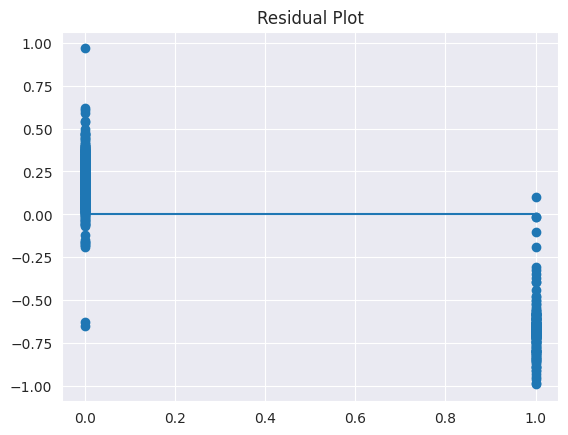

In [34]:
# Lets create a pandas data frame from the predictions
preds = lr_model.summary.predictions.toPandas()

# Lets plot the residuals
plt.scatter(preds['whether'], preds['prediction'] - preds['whether'])
plt.hlines(y=0, xmin=preds['whether'].min(), xmax=preds['whether'].max())
plt.title('Residual Plot')

In [40]:
# export as html with nbconvert
!jupyter nbconvert --to html nicolas_cinera.ipynb

[NbConvertApp] Converting notebook nicolas_cinera.ipynb to html
[NbConvertApp] Writing 638424 bytes to nicolas_cinera.html


### Thank you for the great course!